In [ ]:
!pip install torch torchvision

In [ ]:
import torch
import torchvision

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
log_interval = 10

random_seed = 2022
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: %s" % device)

#60k handwritten digits for train
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)
#10k for test
test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Device: cuda:0


In [ ]:
#network
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01, momentum=0.5)


In [ ]:
#train & test
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), '/tmp/model.pth')
      torch.save(optimizer.state_dict(), '/tmp/optimizer.pth')


def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))
  

import os
if os.path.exists("/tmp/model.pth"):
  os.remove("/tmp/model.pth")
  os.remove("/tmp/optimizer.pth")
  print("Previous model has been")

test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

Previous model has been


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3050, Accuracy: 858/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.347104
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.316271
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.305171
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.283131
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.271820
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.259622
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.192772
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.150468
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.147990
Train Epoch: 1 [5760/60000 (10%)]	Loss: 2.131485
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.024535
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.859812
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.900070
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.788876
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.574270
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.541650
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.424905
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.021533
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.273104
Train Epoch: 1 [12160/6

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


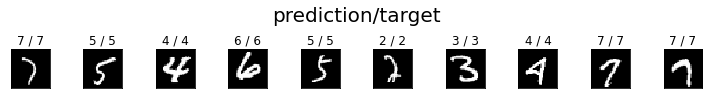

In [ ]:
# prediction
import matplotlib.pyplot as plt
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

with torch.no_grad():
  output = network(example_data)

fig = plt.figure(figsize=(10,2))
fig.suptitle('prediction/target', fontsize=20)
for i in range(10):
  fig.add_subplot(1,10,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("{} / {}".format(output.data.max(1, keepdim=True)[1][i].item(), example_targets[i]))
  plt.xticks([])
  plt.yticks([])